In [15]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [16]:
import numpy as np
import matplotlib.pyplot as plt

from lensim.host import Host
from lensim.simulator import Simulator
from lensim.utils import jain, tail, microsec, kB, Gbps

### 1. Prepare trainning dataset.

In [17]:
packet_size = 5e6
n_hosts = 100
n_loops = 500000
cable_delay = 50
target_delay = 400

In [18]:
%%time
net = Simulator(logger=True)
for _ in range(n_hosts):
    net.add(Host((0, n_loops), cable_delay, target_delay, cwnd=1.5))
lenq, t_acks, cwnds, rtts, throughputs = net.simulate(n_loops, settling=n_loops//2)
all_rtts = np.concatenate(rtts)
tail99 = tail(all_rtts, 0.99)
print("=== Simulation results ===")
print(f'Throughput: {50*throughputs.sum():.1f} Gbps')
print(f"Mean RTT: {np.mean(all_rtts)*1.6e-07/microsec:.1f} us")
print(f"99th-p RTT: {tail99*1.6e-07/microsec:.1f} us")
print(f"Jain's fairness: J={jain(throughputs):.3f}")

Log saved to network_log1
[0]
=== Simulation results ===
Throughput: 50.0 Gbps
Mean RTT: 28.7 us
99th-p RTT: 35.1 us
Jain's fairness: J=1.000
CPU times: user 10 s, sys: 209 ms, total: 10.2 s
Wall time: 9.94 s


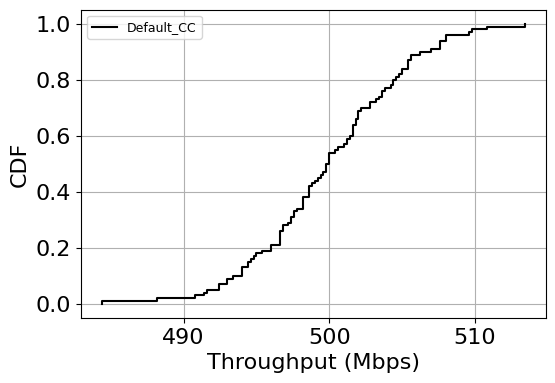

In [19]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1,1, figsize=(6, 4), dpi=100)
ax.ecdf(50e3*throughputs, c='k', label='Default_CC')
ax.grid()
ax.set_ylim([-0.05,1.05])
ax.set_xlabel('Throughput (Mbps)')
ax.set_ylabel('CDF')
ax.legend(loc = 'upper left', fontsize=9)

### 2. Train model

In [20]:
from sklearn.model_selection import train_test_split 
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from regrsim.simulator import NewSimulator
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
import joblib

In [21]:
lines = []
with open('./log/network_log1', 'r') as file:
    lines = file.readlines()
    
X = [s.split(',')[1:11] for s in lines][1:] # cwnd_prev,can_decrease,target_delay,total_acked,pacing_delay,first,rtt,prev_rtt,delay,now
y = [s.split(',')[11] for s in lines][1:] # cwnd
for fs in X: del fs[5]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
model = CatBoostRegressor(verbose=True)

params = {
    'iterations': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=params,
    scoring=['r2', 'neg_root_mean_squared_error'],
    cv=3,                             
    verbose=4,
    n_jobs=-1,
    refit='r2'                    
)

grid_search.fit(X, y)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
0:	learn: 0.2602529	total: 6ms	remaining: 594ms
1:	learn: 0.2580948	total: 13.3ms	remaining: 653ms
2:	learn: 0.2559629	total: 19.3ms	remaining: 624ms
3:	learn: 0.2538264	total: 26.6ms	remaining: 639ms
4:	learn: 0.2517418	total: 32ms	remaining: 608ms
5:	learn: 0.2496938	total: 37.6ms	remaining: 588ms
6:	learn: 0.2476520	total: 44.7ms	remaining: 594ms
7:	learn: 0.2456422	total: 51.2ms	remaining: 589ms
8:	learn: 0.2436498	total: 57.6ms	remaining: 583ms
9:	learn: 0.2416859	total: 63.5ms	remaining: 572ms
10:	learn: 0.2396818	total: 69.4ms	remaining: 561ms
11:	learn: 0.2377515	total: 75.8ms	remaining: 556ms
12:	learn: 0.2358480	total: 81.3ms	remaining: 544ms
13:	learn: 0.2339708	total: 86.9ms	remaining: 534ms
14:	learn: 0.2320563	total: 92.9ms	remaining: 527ms
15:	learn: 0.2302128	total: 98.3ms	remaining: 516ms
16:	learn: 0.2283923	total: 105ms	remaining: 512ms
17:	learn: 0.2265899	total: 111ms	remaining: 504ms
18:	learn: 0.22480

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fd25aa22dd0>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 8], 'iterations': [100, 200, 300, 500],
                         'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.01, 0.05, 0.1]},
             refit='r2', scoring=['r2', 'neg_root_mean_squared_error'],
             verbose=4)

In [23]:
print("Best params: ", grid_search.best_params_)
print("MSE", -grid_search.best_score_)

best_model = grid_search.best_estimator_
pred = best_model.predict(X_test)
print("MSE with y_test:", root_mean_squared_error(y_test, pred))
print("R2 with y_test: ", r2_score(y_test, pred))

Best params:  {'depth': 8, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
MSE -0.9990258657341728
MSE with y_test: 0.007260285311556822
R2 with y_test:  0.9992305864988807


### 3. Integration model in simulator

In [24]:
%%time

joblib.dump(best_model, 'model.pkl')

new_net = NewSimulator(logger=True)
for _ in range(n_hosts):
    new_net.add(Host((0, n_loops), cable_delay, target_delay, cwnd=1.5))
lenq_, t_acks_, cwnds_, rtts_, throughputs_ = new_net.simulate(n_loops, settling=n_loops//2)
all_rtts_ = np.concatenate(rtts_)
tail99 = tail(all_rtts_, 0.99)
print("=== Simulation results ===")
print(f'Throughput: {50*throughputs_.sum():.1f} Gbps')
print(f"Mean RTT: {np.mean(all_rtts_)*1.6e-07/microsec:.1f} us")
print(f"99th-p RTT: {tail99*1.6e-07/microsec:.1f} us")
print(f"Jain's fairness: J={jain(throughputs_):.3f}")

Log saved to network_log2
[0]
=== Simulation results ===
Throughput: 50.0 Gbps
Mean RTT: 28.7 us
99th-p RTT: 35.1 us
Jain's fairness: J=1.000
CPU times: user 12.2 s, sys: 259 ms, total: 12.4 s
Wall time: 12.9 s


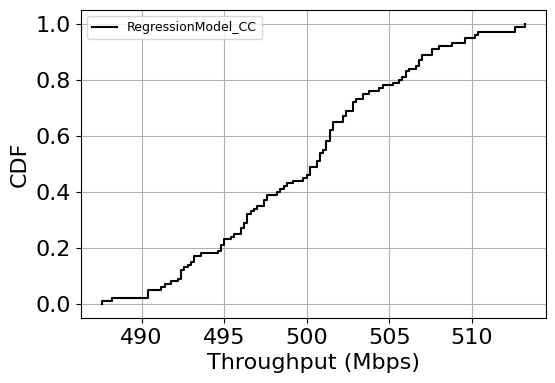

In [25]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1,1, figsize=(6, 4), dpi=100)
ax.ecdf(50e3*throughputs_, c='k', label='RegressionModel_CC')
ax.grid()
ax.set_ylim([-0.05,1.05])
ax.set_xlabel('Throughput (Mbps)')
ax.set_ylabel('CDF')
ax.legend(loc = 'upper left', fontsize=9)

### 4. Comparing results

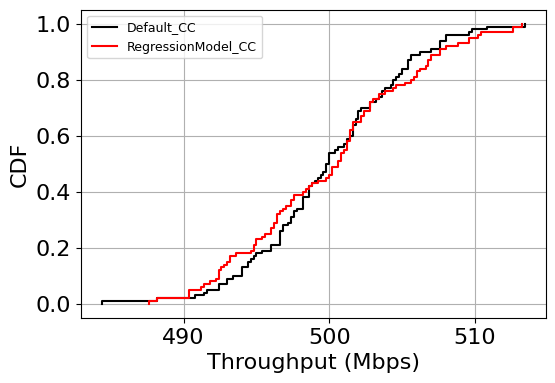

In [26]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1,1, figsize=(6, 4), dpi=100)
ax.ecdf(50e3*throughputs, c='k', label='Default_CC')
ax.ecdf(50e3*throughputs_, c='r', label='RegressionModel_CC')
ax.grid()
ax.set_ylim([-0.05,1.05])
ax.set_xlabel('Throughput (Mbps)')
ax.set_ylabel('CDF')
ax.legend(loc = 'upper left', fontsize=9)